# Análisis tramas BLE

## Introducción

Primer acercamiento al análisis de los datos generados por un módulo ESP32 encargado de capturar las tramas Bluetooth generadas por los dispositivos cercanos.
Este estudio tiene como objetivo identificar patrones en los que se relacionan los datos para así poder aplicar algoritmos de Machine Learning para ser capaz de predecir el número de personas en un recinto.

En primer, cargaremos un datasheet generado por los receptores y por otro sensor colocado en la entrada de la biblioteca capaz de contabilizar el número de personas que entran y salen. Veremos que aspecto tienen los datos:

In [89]:
#from google.colab import drive
#drive.mount('/content/drive')

In [90]:
#!pip install dython

In [91]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from dython.nominal import associations
from sklearn.metrics import mean_squared_error

In [92]:
"""
data_20220712 = pd.read_csv('/content/drive/MyDrive/UPCT/ble-filter-clean-P_2022-07-12.csv', sep=';')
data_20220713 = pd.read_csv('/content/drive/MyDrive/UPCT/ble-filter-clean-P_2022-07-13.csv', sep=';')
data_20220714 = pd.read_csv('/content/drive/MyDrive/UPCT/ble-filter-clean-P_2022-07-14.csv', sep=';')
data_20220715 = pd.read_csv('/content/drive/MyDrive/UPCT/ble-filter-clean-P_2022-07-15.csv', sep=';')
personCount_20220712 = pd.read_csv('/content/drive/MyDrive/UPCT/PersonCount_2022-07-12_7-22.csv', sep=';')
personCount_20220713 = pd.read_csv('/content/drive/MyDrive/UPCT/PersonCount_2022-07-13_7-22.csv', sep=';')
personCount_20220714 = pd.read_csv('/content/drive/MyDrive/UPCT/PersonCount_2022-07-14_7-22.csv', sep=';')
personCount_20220715 = pd.read_csv('/content/drive/MyDrive/UPCT/PersonCount_2022-07-15_7-22.csv', sep=';')
"""
data_20220712 = pd.read_csv('docs/ble-filter-clean-P_2022-07-12.csv', sep=';')
data_20220713 = pd.read_csv('docs/ble-filter-clean-P_2022-07-13.csv', sep=';')
data_20220714 = pd.read_csv('docs/ble-filter-clean-P_2022-07-14.csv', sep=';')
data_20220715 = pd.read_csv('docs/ble-filter-clean-P_2022-07-15.csv', sep=';')
personCount_20220712 = pd.read_csv('docs/PersonCount_2022-07-12_7-22.csv', sep=';')
personCount_20220713 = pd.read_csv('docs/PersonCount_2022-07-13_7-22.csv', sep=';')
personCount_20220714 = pd.read_csv('docs/PersonCount_2022-07-14_7-22.csv', sep=';')
personCount_20220715 = pd.read_csv('docs/PersonCount_2022-07-15_7-22.csv', sep=';')

A continuación se han declarado todas las funciones necesarias para obtener los resultados mostrados en este notebook con la intención de replicar los calculos para más de un conjunto de datos de la manera más rápida y sencilla posible.

In [112]:
def transformTimestamp(data, personCount):
    """Función que transforma los campos Fecha y Hora del conjunto de dato proporcionado por el contador de personas a un Timestamp usable"""

    timestamp = []
    for i in range(len(personCount)):
        timestamp.append(personCount['Fecha'][i] + ' ' + personCount['Hora'][i])
    personCount["Timestamp"] = pd.to_datetime(timestamp, dayfirst=True)
    data["Timestamp int."] = pd.to_datetime(data["Timestamp int."])
    data = data.rename(columns={"Timestamp int.": "Timestamp"})
    return data, personCount

def parsePersonCount(time, personCount):
    """Función que devuelve un Dataframe con una columna Timestamp y otra columna con el número de personas detectadas por el contador de personas"""

    zeroList = pd.Series(np.zeros(len(time)))
    fullPersonCountInterval = pd.DataFrame({'Timestamp': pd.to_datetime(time), 'personCount': zeroList})
    personCountInterval = personCount.groupby(pd.Grouper(key='Timestamp', freq='5T'))["Estimación nº Personas"].last()
    booleanPersonCountInterval = personCountInterval.isna()

    for i in range(len(personCountInterval)):
        if booleanPersonCountInterval[i]:
            personCountInterval[i] = personCountInterval[i-1]

    for i in range(len(time)):
        if len(personCountInterval.loc[personCountInterval.index == fullPersonCountInterval["Timestamp"][i]]) != 0:
            nPeople = personCountInterval.loc[personCountInterval.index == fullPersonCountInterval["Timestamp"][i]][0]
            fullPersonCountInterval["personCount"][i] = int(nPeople)

    return fullPersonCountInterval

def generateTimeSeries(data):
    """Función que devuelve una Serie con un Timestamp espaciado según el conjunto de datos pasado como parámetro"""

    timeSeries = pd.Series(pd.date_range(data["Timestamp"].iloc[0], data["Timestamp"].iloc[-1], freq='5T'))
    return timeSeries

def uniqueValues(data):
    """Función que imprime el total de valores únicos de cada columna del conjunto de datos """
    print(data.nunique().sort_values())
    print('')
    print('Número de filas total: ', data.shape[0])

def totalDevicesSummary(data):
    """Función que imprime un resumen del número total de dispositivos captados globalmente y por Raspberry"""
    MACTypeData = data.groupby(pd.Grouper(key='Raspberry')).nunique()["MAC"].sort_index()
    sumTotalDevices = 0
    for i in range(np.shape(MACTypeData)[0]):
        print('Número de dispositivos captados por la', MACTypeData.index[i], ':', MACTypeData[i])
        sumTotalDevices = sumTotalDevices + MACTypeData[i]
    totalDevices = len(data.MAC.unique())
    print('Sumatorio del número total de dispositivos captados por cada receptor:', sumTotalDevices)
    print('Número total de dispositivos captados:', totalDevices)

def plotRandomPublicMAC(data):
    """Función que representa un histograma con la cantidad de dispositivos con MAC Random y Pública"""
    MACTypeData = data.groupby(pd.Grouper(key='Tipo MAC')).nunique()
    plt.bar(MACTypeData.index, MACTypeData.MAC)
    plt.xlabel("MAC Address Type")
    plt.ylabel("MAC Address's Number")
    plt.title("Random vs Public MAC Address")
    plt.show()

def plotTotalDevices(data, fullPersonCountInterval):
    """Función que representa el número de dispositivos únicos captados en cada intervalo de tiempo"""

    nDevicesInterval = data.groupby(pd.Grouper(key='Timestamp')).nunique()
    nDevicesIntervalRand = data.loc[data['Tipo MAC'] == 'Random']
    nDevicesIntervalRand = nDevicesIntervalRand.groupby(pd.Grouper(key='Timestamp')).nunique()
    plt.figure(figsize=(10,6))
    plt.plot(nDevicesInterval.index, nDevicesInterval.MAC, color='blue', label='Public+Random')
    plt.plot(nDevicesIntervalRand.index, nDevicesIntervalRand.MAC, color='green', label='Random')
    plt.plot(fullPersonCountInterval.Timestamp, fullPersonCountInterval.personCount, color='red', label='Person Count')
    plt.xlabel("Timestamp")
    plt.ylabel("Devices and People")
    plt.title("Device's Number along Time")
    plt.legend()
    plt.show()

def getDatasheet(data, rand):
    """Función que devuelve un conjunto de datos filtrado por tipo de MAC Random o el conjunto completo"""

    if rand:
        nDevicesInterval = data.loc[data['Tipo MAC'] == 'Random']
    else:
        nDevicesInterval = data
    return nDevicesInterval

def parseDataByRaspberry(data, rand=True):
    """Función que devuelve un conjunto de datos filtrado por cada Raspberry. Devuelve un conjunto por Raspberry.
    Se le puede indicar usar todo el conjunto o solamente las MAC Random"""

    nDevicesInterval = getDatasheet(data, rand)
    dataInterval1 = nDevicesInterval.loc[nDevicesInterval['Raspberry'] == 'Raspberry1']
    dataInterval2 = nDevicesInterval.loc[nDevicesInterval['Raspberry'] == 'Raspberry2']
    dataInterval3 = nDevicesInterval.loc[nDevicesInterval['Raspberry'] == 'Raspberry3']
    dataInterval4 = nDevicesInterval.loc[nDevicesInterval['Raspberry'] == 'Raspberry5']
    dataInterval5 = nDevicesInterval.loc[nDevicesInterval['Raspberry'] == 'Raspberry7']
    return dataInterval1, dataInterval2, dataInterval3, dataInterval4, dataInterval5

def parseDataByRaspberryTime(data, rand=True):
    """Función que devuelve conjuntos de datos con valores únicos filtrados por Raspberry y agrupados por Timestamp"""

    dataInterval1, dataInterval2, dataInterval3, dataInterval4, dataInterval5 = parseDataByRaspberry(data, rand)
    dataInterval1 = dataInterval1.groupby(['Timestamp']).nunique()
    dataInterval2 = dataInterval2.groupby(['Timestamp']).nunique()
    dataInterval3 = dataInterval3.groupby(['Timestamp']).nunique()
    dataInterval4 = dataInterval4.groupby(['Timestamp']).nunique()
    dataInterval5 = dataInterval5.groupby(['Timestamp']).nunique()
    return dataInterval1, dataInterval2, dataInterval3, dataInterval4, dataInterval5

def getDeviceNumberByRaspberry(data, rand):
    """Función que devuelve el número de dispositivos en cada intervalo de tiempo para cada Raspberry"""

    dataInterval1, dataInterval2, dataInterval3, dataInterval4, dataInterval5 = parseDataByRaspberryTime(data, rand)
    nDevicesRaspberry1 = len(dataInterval1.groupby("MAC").count())
    nDevicesRaspberry2 = len(dataInterval2.groupby("MAC").count())
    nDevicesRaspberry3 = len(dataInterval3.groupby("MAC").count())
    nDevicesRaspberry4 = len(dataInterval4.groupby("MAC").count())
    nDevicesRaspberry5 = len(dataInterval5.groupby("MAC").count())
    return nDevicesRaspberry1, nDevicesRaspberry2, nDevicesRaspberry3, nDevicesRaspberry4, nDevicesRaspberry5

def plotTotalDevicesByRaspberry(data, fullPersonCountInterval, rand=True, initHour=None, endHour=None):
    """Función que representa el número de dispositivos en cada intervalo de tiempo para cada Raspberry"""

    nDevicesIntervalDataRaspberry1, nDevicesIntervalDataRaspberry2, nDevicesIntervalDataRaspberry3, nDevicesIntervalDataRaspberry5, nDevicesIntervalDataRaspberry7 = parseDataByRaspberryTime(data, rand)
    plt.figure(figsize=(10,6))
    plt.plot(nDevicesIntervalDataRaspberry1.index, nDevicesIntervalDataRaspberry1.MAC, color='blue', label='Raspberry1')
    plt.plot(nDevicesIntervalDataRaspberry2.index, nDevicesIntervalDataRaspberry2.MAC, color='green', label='Raspberry2')
    plt.plot(nDevicesIntervalDataRaspberry3.index, nDevicesIntervalDataRaspberry3.MAC, color='purple', label='Raspberry3')
    plt.plot(nDevicesIntervalDataRaspberry5.index, nDevicesIntervalDataRaspberry5.MAC, color='deeppink', label='Raspberry5')
    plt.plot(nDevicesIntervalDataRaspberry7.index, nDevicesIntervalDataRaspberry7.MAC, color='gold', label='Raspberry7')
    plt.plot(fullPersonCountInterval.Timestamp, fullPersonCountInterval.personCount, color='red', label='Person Count')
    plt.xlabel("Timestamp")
    plt.ylabel("Devices and People")
    plt.title("Device's Number along Time per Raspberry")
    if (initHour is not None) and (endHour is not None):
        initialDate = dt.datetime(data['Timestamp'][0].year, data['Timestamp'][0].month, data['Timestamp'][0].day, hour=initHour)
        finalDate = dt.datetime(data['Timestamp'][0].year, data['Timestamp'][0].month, data['Timestamp'][0].day, hour=endHour)
        plt.xlim(initialDate, finalDate)
    plt.legend()
    plt.show()

def errorCalc(data, fullPersonCountInterval, rand=True, startHour='8:00:00', finalHour='21:00:00'):
    """Función que devuelve el error medio y el error cuadrático medio entre el número de dispositivos captados y el número de personas contadas por el contador de personas"""

    nDevicesInterval = getDatasheet(data, rand)
    nDevicesInterval = nDevicesInterval.groupby(pd.Grouper(key='Timestamp')).nunique()
    date = nDevicesInterval.index[0].date().strftime('%Y-%m-%d')
    init = date + ' ' + startHour
    end = date + ' ' + finalHour
    nDevicesInterval = nDevicesInterval.loc[init:end]
    fullPersonCountInterval = fullPersonCountInterval.loc[(fullPersonCountInterval["Timestamp"] >= init) & (fullPersonCountInterval["Timestamp"] <= end)]
    errorInterval = fullPersonCountInterval.personCount.values - nDevicesInterval.MAC.values
    quadraticErrorInterval = mean_squared_error(fullPersonCountInterval.personCount.values, nDevicesInterval.MAC.values)
    error = np.round(errorInterval.mean(), 3)
    quadraticError = np.round(quadraticErrorInterval.mean(), 3)
    print("El error medio del día es:", error)
    print("El error cuadrático medio del día es:", quadraticError)
    return error, quadraticError

def rssiCalc(data, rand=True, initValue=10, endValue=50):
    """Función que calcula el número de dispositivos cuyos mensajes se encuentran en unos umbrales de potencia modificables"""

    nDevicesInterval = getDatasheet(data, rand)
    minRSSI = nDevicesInterval["RSSI promedio"].min()
    values = np.round(np.linspace(initValue, endValue, 5)/100,2)

    rssiDeviceInterval1 = nDevicesInterval.loc[(nDevicesInterval["RSSI promedio"] <= minRSSI - minRSSI*values[0])]
    nDevices1 = rssiDeviceInterval1.groupby("MAC").count()
    print(len(nDevices1))
    rssiDeviceInterval1 = rssiDeviceInterval1.groupby("Timestamp").count()

    rssiDeviceInterval2 = nDevicesInterval.loc[(nDevicesInterval["RSSI promedio"] > minRSSI - minRSSI*values[0]) & (nDevicesInterval["RSSI promedio"] <= minRSSI - minRSSI*values[1])]
    nDevices2 = rssiDeviceInterval2.groupby("MAC").count()
    print(len(nDevices2))
    rssiDeviceInterval2 = rssiDeviceInterval2.groupby("Timestamp").count()

    rssiDeviceInterval3 = nDevicesInterval.loc[(nDevicesInterval["RSSI promedio"] > minRSSI - minRSSI*values[1]) & (nDevicesInterval["RSSI promedio"] <= minRSSI - minRSSI*values[2])]
    nDevices3 = rssiDeviceInterval3.groupby("MAC").count()
    print(len(nDevices3))
    rssiDeviceInterval3 = rssiDeviceInterval3.groupby("Timestamp").count()

    rssiDeviceInterval4 = nDevicesInterval.loc[(nDevicesInterval["RSSI promedio"] > minRSSI - minRSSI*values[2]) & (nDevicesInterval["RSSI promedio"] <= minRSSI - minRSSI*values[3])]
    nDevices4 = rssiDeviceInterval4.groupby("MAC").count()
    print(len(nDevices4))
    rssiDeviceInterval4 = rssiDeviceInterval4.groupby("Timestamp").count()

    rssiDeviceInterval5 = nDevicesInterval.loc[(nDevicesInterval["RSSI promedio"] > minRSSI - minRSSI*values[3]) & (nDevicesInterval["RSSI promedio"] <= minRSSI - minRSSI*values[4])]
    nDevices5 = rssiDeviceInterval5.groupby("MAC").count()
    print(len(nDevices5))
    rssiDeviceInterval5 = rssiDeviceInterval5.groupby("Timestamp").count()

    rssiDeviceInterval6 = nDevicesInterval.loc[nDevicesInterval["RSSI promedio"] > minRSSI - minRSSI*values[4]]
    nDevices6 = rssiDeviceInterval6.groupby("MAC").count()
    print(len(nDevices6))
    rssiDeviceInterval6 = rssiDeviceInterval6.groupby("Timestamp").count()

    return rssiDeviceInterval1, rssiDeviceInterval2, rssiDeviceInterval3, rssiDeviceInterval4, rssiDeviceInterval5, rssiDeviceInterval6, values*100

def plotTotalDevicesByRSSI(data, rand=True, initValue=10, endValue=50):
    """Función que representa el número de dispositivos cuyos mensajes se encuentran en unos umbrales de potencia modificables"""

    rssiDeviceInterval1, rssiDeviceInterval2, rssiDeviceInterval3, rssiDeviceInterval4, rssiDeviceInterval5, rssiDeviceInterval6, values = rssiCalc(data, rand, initValue, endValue)
    plt.figure(figsize=(10,6))
    plt.plot(rssiDeviceInterval1.index, rssiDeviceInterval1.MAC, color='blue', label='RSSI <= '+str(values[0])+'%')
    plt.plot(rssiDeviceInterval2.index, rssiDeviceInterval2.MAC, color='green', label=str(values[0])+'% < RSSI <= '+str(values[1])+'%')
    plt.plot(rssiDeviceInterval3.index, rssiDeviceInterval3.MAC, color='purple', label=str(values[1])+'% < RSSI <= '+str(values[2])+'%')
    plt.plot(rssiDeviceInterval4.index, rssiDeviceInterval4.MAC, color='deeppink', label=str(values[2])+'% < RSSI <= '+str(values[3])+'%')
    plt.plot(rssiDeviceInterval5.index, rssiDeviceInterval5.MAC, color='gold', label=str(values[3])+'% < RSSI <= '+str(values[4])+'%')
    plt.plot(rssiDeviceInterval6.index, rssiDeviceInterval6.MAC, color='red', label=str(values[4])+'% < RSSI')
    plt.xlabel("Timestamp")
    plt.ylabel("Device's Number")
    plt.title("Device's Number by RSSI Level")
    plt.legend()
    plt.show()

def histTotalDevicesByRSSIAndRaspberry(data, rand=True, bins=20):
    """Función que representa en forma de histograma la cantidad de dispositivos comprendidos entre el nivel de señal mínimo y máximo"""

    nDevicesInterval = getDatasheet(data, rand)
    rssiDeviceInterval1, rssiDeviceInterval2, rssiDeviceInterval3, rssiDeviceInterval4, rssiDeviceInterval5 = parseDataByRaspberry(nDevicesInterval)

    rssiDeviceInterval1 = rssiDeviceInterval1.groupby(pd.Grouper(key='MAC')).mean()
    rssiDeviceInterval2 = rssiDeviceInterval2.groupby(pd.Grouper(key='MAC')).mean()
    rssiDeviceInterval3 = rssiDeviceInterval3.groupby(pd.Grouper(key='MAC')).mean()
    rssiDeviceInterval4 = rssiDeviceInterval4.groupby(pd.Grouper(key='MAC')).mean()
    rssiDeviceInterval5 = rssiDeviceInterval5.groupby(pd.Grouper(key='MAC')).mean()

    figure, axis = plt.subplots(5, 1, sharex=True, sharey=True)
    figure.set_size_inches(10,15)
    axis[0].hist(rssiDeviceInterval1['RSSI promedio'], bins, color='blue')
    axis[0].set_title("Raspberry1")
    axis[1].hist(rssiDeviceInterval2['RSSI promedio'], bins, color='green')
    axis[1].set_title("Raspberry2")
    axis[2].hist(rssiDeviceInterval3['RSSI promedio'], bins, color='red')
    axis[2].set_title("Raspberry3")
    axis[3].hist(rssiDeviceInterval4['RSSI promedio'], bins, color='deeppink')
    axis[3].set_title("Raspberry5")
    axis[4].hist(rssiDeviceInterval5['RSSI promedio'], bins, color='gold')
    axis[4].set_title("Raspberry7")

def messageCalc(data, rand=True, initValue=25, endValue=125):
    """Función que devuelve el número de dispositivos que se encuentran en unos umbrales en función del número de mensajes en cada intervalo de tiempo"""

    nDevicesInterval = getDatasheet(data, rand)
    values = np.linspace(initValue, endValue, 5)
    values = values.astype(int)

    messageDeviceInterval1 = nDevicesInterval.loc[(nDevicesInterval["Nº Mensajes"] <= values[0])]
    nDevices1 = messageDeviceInterval1.groupby("MAC").count()
    print(len(nDevices1))
    messageDeviceInterval1 = messageDeviceInterval1.groupby("Timestamp").count()

    messageDeviceInterval2 = nDevicesInterval.loc[(nDevicesInterval["Nº Mensajes"] > values[0]) & (nDevicesInterval["Nº Mensajes"] <= values[1])]
    nDevices2 = messageDeviceInterval2.groupby("MAC").count()
    print(len(nDevices2))
    messageDeviceInterval2 = messageDeviceInterval2.groupby("Timestamp").count()

    messageDeviceInterval3 = nDevicesInterval.loc[(nDevicesInterval["Nº Mensajes"] > values[1]) & (nDevicesInterval["Nº Mensajes"] <= values[2])]
    nDevices3 = messageDeviceInterval3.groupby("MAC").count()
    print(len(nDevices3))
    messageDeviceInterval3 = messageDeviceInterval3.groupby("Timestamp").count()

    messageDeviceInterval4 = nDevicesInterval.loc[(nDevicesInterval["Nº Mensajes"] > values[2]) & (nDevicesInterval["Nº Mensajes"] <= values[3])]
    nDevices4 = messageDeviceInterval4.groupby("MAC").count()
    print(len(nDevices4))
    messageDeviceInterval4 = messageDeviceInterval4.groupby("Timestamp").count()

    messageDeviceInterval5 = nDevicesInterval.loc[(nDevicesInterval["Nº Mensajes"] > values[3]) & (nDevicesInterval["Nº Mensajes"] <= values[4])]
    nDevices5 = messageDeviceInterval5.groupby("MAC").count()
    print(len(nDevices5))
    messageDeviceInterval5 = messageDeviceInterval5.groupby("Timestamp").count()

    messageDeviceInterval6 = nDevicesInterval.loc[nDevicesInterval["Nº Mensajes"] > values[4]]
    nDevices6 = messageDeviceInterval6.groupby("MAC").count()
    print(len(nDevices6))
    messageDeviceInterval6 = messageDeviceInterval6.groupby("Timestamp").count()

    return messageDeviceInterval1, messageDeviceInterval2, messageDeviceInterval3, messageDeviceInterval4, messageDeviceInterval5, messageDeviceInterval6, values

def plotTotalDevicesByMessage(data, fullPersonCountInterval, rand=True, initValue=25, endValue=125):
    """Función que representa el número de dispositivos que se encuentran en unos umbrales en función del número de mensajes en cada intervalo de tiempo"""

    messageDeviceInterval1, messageDeviceInterval2, messageDeviceInterval3, messageDeviceInterval4, messageDeviceInterval5, messageDeviceInterval6, values = messageCalc(data, rand, initValue, endValue)
    values = values.astype(str)
    plt.figure(figsize=(10,6))
    plt.plot(messageDeviceInterval1.index, messageDeviceInterval1['Nº Mensajes'], color='blue', label=' nMessage <= '+values[0])
    plt.plot(messageDeviceInterval2.index, messageDeviceInterval2['Nº Mensajes'], color='green', label=values[0]+' < nMessage <= '+values[1])
    plt.plot(messageDeviceInterval3.index, messageDeviceInterval3['Nº Mensajes'], color='purple', label=values[1]+' < nMessage <= '+values[2])
    plt.plot(messageDeviceInterval4.index, messageDeviceInterval4['Nº Mensajes'], color='deeppink', label=values[2]+' < nMessage <= '+values[3])
    plt.plot(messageDeviceInterval5.index, messageDeviceInterval5['Nº Mensajes'], color='gold', label=values[3]+' < nMessage <= '+values[4])
    plt.plot(messageDeviceInterval6.index, messageDeviceInterval6['Nº Mensajes'], color='red', label=values[4]+' < nMessage')
    plt.plot(fullPersonCountInterval.Timestamp, fullPersonCountInterval.personCount, color='cyan', label='Person Count')
    plt.xlabel("Timestamp")
    plt.ylabel("Device's Number")
    plt.title("Number of Devices by Message's Number")
    plt.legend()
    plt.show()

def getMetricsRoom(data, rand=True, RSSIThreshold=-99):
    """Función que muestra métricas únicamente de la sala de estudio, como número de dispositivos captados por Raspberry, número de mensajes captados por Raspberry, tanto por ciento de dispositivos con mensajes por debajo de cierto umbral de mensajes y tanto por ciento de dispositivos con mensajes por debajo de cierto umbral de potencia"""

    _, nDevicesInterval2, _, nDevicesInterval4, nDevicesInterval5 = parseDataByRaspberry(data, rand)
    _, nDevicesRaspberry2, _, nDevicesRaspberry4, nDevicesRaspberry5 = getDeviceNumberByRaspberry(data, rand)
    print("Número dispositivos captados por la Raspberry2:", nDevicesRaspberry2)
    print("Número dispositivos captados por la Raspberry5:", nDevicesRaspberry4)
    print("Número dispositivos captados por la Raspberry7:", nDevicesRaspberry5)
    print('')

    nMessageRaspberry2 = nDevicesInterval2["Nº Mensajes"].sum()
    nMessageRaspberry5 = nDevicesInterval4["Nº Mensajes"].sum()
    nMessageRaspberry7 = nDevicesInterval5["Nº Mensajes"].sum()
    print("Número de mensajes captados por la Raspberry2:", nMessageRaspberry2)
    print("Número de mensajes captados por la Raspberry5:", nMessageRaspberry5)
    print("Número de mensajes captados por la Raspberry7:", nMessageRaspberry7)
    print('')

    filterRaspberry2 = nDevicesInterval2.loc[nDevicesInterval2["RSSI promedio"] < RSSIThreshold]
    nMessageFilterRaspberry2 = filterRaspberry2["Nº Mensajes"].sum()

    filterRaspberry5 = nDevicesInterval4.loc[nDevicesInterval4["RSSI promedio"] < RSSIThreshold]
    nMessageFilterRaspberry5 = filterRaspberry5["Nº Mensajes"].sum()

    filterRaspberry7 = nDevicesInterval5.loc[nDevicesInterval5["RSSI promedio"] < RSSIThreshold]
    nMessageFilterRaspberry7 = filterRaspberry7["Nº Mensajes"].sum()

    print("Tanto por ciento de mensajes por debajo de "+str(RSSIThreshold)+" dB en Raspberry2:", np.round(nMessageFilterRaspberry2/nMessageRaspberry2*100, 4), "%")
    print("Tanto por ciento de mensajes por debajo de "+str(RSSIThreshold)+" dB en Raspberry5:", np.round(nMessageFilterRaspberry5/nMessageRaspberry5*100, 4), "%")
    print("Tanto por ciento de mensajes por debajo de "+str(RSSIThreshold)+" dB en Raspberry7:", np.round(nMessageFilterRaspberry7/nMessageRaspberry7*100, 4), "%")
    print('')

    nDeviceRaspberry2 = nDevicesInterval2["MAC"].count()
    nDeviceRaspberry5 = nDevicesInterval4["MAC"].count()
    nDeviceRaspberry7 = nDevicesInterval5["MAC"].count()
    nDeviceFilterRaspberry2 = filterRaspberry2["MAC"].count()
    nDeviceFilterRaspberry5 = filterRaspberry5["MAC"].count()
    nDeviceFilterRaspberry7 = filterRaspberry7["MAC"].count()
    print("Tanto por ciento de dispositivos con mensajes por debajo de "+str(RSSIThreshold)+" dB en Raspberry2:", np.round(nDeviceFilterRaspberry2/nDeviceRaspberry2*100, 4), "%")
    print("Tanto por ciento de dispositivos con mensajes por debajo de "+str(RSSIThreshold)+" dB en Raspberry5:", np.round(nDeviceFilterRaspberry5/nDeviceRaspberry5*100, 4), "%")
    print("Tanto por ciento de dispositivos con mensajes por debajo de "+str(RSSIThreshold)+" dB en Raspberry7:", np.round(nDeviceFilterRaspberry7/nDeviceRaspberry7*100, 4), "%")
    print('')

def devicesOverlapRoom(data, time, rand=True):
    """Función que devuelve únicamente de la sala de estudio un conjunto de datos que muestran por cuantas Raspberries ha sido captado un dispositivo, además de distinguir por cuál de ellas.
     También para el caso especial de ser captado por todas, por la pareja 2-5 o la pareja 5-7.
     Por último el tanto por ciento de direcciones registradas por todas las anteriores posibilidades por separado"""

    _, nDevicesInterval2, _, nDevicesInterval4, nDevicesInterval5 = parseDataByRaspberry(data, rand)
    nDevicesIntervalDataRaspberry2Merge = nDevicesInterval2.drop(["Nº Mensajes", "Tipo MAC", "Tipo ADV", "BLE Size", "RSP Size", "Indice int. muestreo", "Timestamp inicial", "BLE Data"], axis=1)
    nDevicesIntervalDataRaspberry5Merge = nDevicesInterval4.drop(["Nº Mensajes", "Tipo MAC", "Tipo ADV", "BLE Size", "RSP Size", "Indice int. muestreo", "Timestamp inicial", "BLE Data"], axis=1)
    nDevicesIntervalDataRaspberry7Merge = nDevicesInterval5.drop(["Nº Mensajes", "Tipo MAC", "Tipo ADV", "BLE Size", "RSP Size", "Indice int. muestreo", "Timestamp inicial", "BLE Data"], axis=1)

    nDevicesIntervalDataRaspberry2_5Merge = nDevicesIntervalDataRaspberry2Merge.merge(nDevicesIntervalDataRaspberry5Merge, how='outer', on=("Timestamp", "MAC"), copy=False)
    nDevicesIntervalDataRaspberry2_5_7Merge = nDevicesIntervalDataRaspberry2_5Merge.merge(nDevicesIntervalDataRaspberry7Merge, how='outer', on=("Timestamp","MAC"), copy=False)
    deviceSummary = pd.DataFrame(columns=['Timestamp', 'MAC', 'Raspberry', 'Total'])
    deviceOverlap = pd.DataFrame(columns=['Timestamp', 'MAC', 'Raspberry'])
    deviceOverlapRate = pd.DataFrame(columns=['Timestamp', 'Rate_2_5_7', 'Rate_2_5', 'Rate_5_7'])

    for i in range(len(time)):
        group = nDevicesIntervalDataRaspberry2_5_7Merge.loc[nDevicesIntervalDataRaspberry2_5_7Merge["Timestamp"] == time[i]]
        group = group.groupby(["Timestamp", "MAC"]).nunique()
        total_2_5_7, total_2_5, total_5_7 = 0, 0, 0
        for j in range(len(group)):
            name = "Raspberry"
            total = 0
            if group["Raspberry_x"][j] == 1:
                name = name + "_2"
                total = total + 1
            if group["Raspberry_y"][j] == 1:
                name = name + "_5"
                total = total + 1
            if group["Raspberry"][j] == 1:
                name = name + "_7"
                total = total + 1
            df = pd.DataFrame([[time[i], group.index[j][1], name, total]],
                              columns=['Timestamp', 'MAC', 'Raspberry', 'Total'])
            deviceSummary = pd.concat([deviceSummary, df], ignore_index=True)
            if name == 'Raspberry_2_5_7':
                total_2_5_7 = total_2_5_7 + 1
            if name == 'Raspberry_2_5':
                total_2_5 = total_2_5 + 1
            if name == 'Raspberry_5_7':
                total_5_7 = total_5_7 + 1
            if name == 'Raspberry_2_5_7' or name == 'Raspberry_2_5' or name == 'Raspberry_5_7':
                df2 = pd.DataFrame([[time[i], group.index[j][1], name]], columns=['Timestamp', 'MAC', 'Raspberry'])
                deviceOverlap = pd.concat([deviceOverlap, df2], ignore_index=True)
        df3 = pd.DataFrame([[time[i], np.round(total_2_5_7/len(group)*100, 3), np.round(total_2_5/len(group)*100, 3), np.round(total_5_7/len(group)*100, 3)]], columns=['Timestamp', 'Rate_2_5_7', 'Rate_2_5', 'Rate_5_7'])
        deviceOverlapRate = pd.concat([deviceOverlapRate, df3], ignore_index=True)
    devicesByRasp257 = deviceOverlap.loc[deviceOverlap["Raspberry"] == 'Raspberry_2_5_7']["MAC"].nunique()
    devicesByRasp25 = deviceOverlap.loc[deviceOverlap["Raspberry"] == 'Raspberry_2_5']["MAC"].nunique()
    devicesByRasp57 = deviceOverlap.loc[deviceOverlap["Raspberry"] == 'Raspberry_5_7']["MAC"].nunique()
    print(deviceSummary.head(10))
    print('')
    print(deviceOverlap.head(10))
    print('')
    print(deviceOverlapRate.head(10))
    print('')
    print('Número de dispositivos captados por las Raspberries 2, 5 y 7: '+str(devicesByRasp257))
    print('Número de dispositivos captados por las Raspberries 2 y 5: '+str(devicesByRasp25))
    print('Número de dispositivos captados por las Raspberries 5 y 7: '+str(devicesByRasp57))
    return deviceSummary, deviceOverlap, deviceOverlapRate

def plotDevicesOverlapRoom(deviceOverlapRate):
    """Función que representa únicamente de la sala de estudio la evolución del tanto por ciento de dispositivos registrados en el mismo intervalo de tiempo por todas las Raspberries, por la pareja 2-5 o la pareja 5-7"""

    plt.figure(figsize=(10,6))
    plt.plot(deviceOverlapRate.Timestamp, deviceOverlapRate.Rate_2_5, color='red', label='2_5')
    plt.plot(deviceOverlapRate.Timestamp, deviceOverlapRate.Rate_5_7, color='blue', label='5_7')
    plt.plot(deviceOverlapRate.Timestamp, deviceOverlapRate.Rate_2_5_7, color='green', label='2_5_7')
    plt.xlabel("Timestamp")
    plt.ylabel("% of Devices")
    plt.title("% of Devices Caught by 2_5, 5_7 and 2_5_7")
    plt.legend()
    plt.show()

def devicesOverlapRoomDetail(time, deviceSummary):
    """Función que devuelve únicamente de la sala de estudio un conjunto de datos en el que se muestra el tanto por ciento de dispositivos que estaban registrados en el intervalo de tiempo anterior y otro conjunto de datos donde se detalle para cada uno de los dispositivos"""

    devicesInPreviousInterval = pd.DataFrame(columns=['Timestamp', 'Rate'])
    devicesMACInPreviousInterval = pd.DataFrame(columns=['Timestamp', 'MAC', 'isIn'])

    for i in range(len(time)):
        if i == 0:
            MACList = deviceSummary.loc[deviceSummary["Timestamp"] == time[i]]["MAC"]
            for z in range(len(MACList)):
                df2 = pd.DataFrame([[time[i], MACList[z], 'N']], columns=['Timestamp', 'MAC', 'isIn'])
                devicesMACInPreviousInterval = pd.concat([devicesMACInPreviousInterval, df2], ignore_index=True)
            df = pd.DataFrame([[time[i], 0]], columns=['Timestamp', 'Rate'])
            devicesInPreviousInterval = pd.concat([devicesInPreviousInterval, df], ignore_index=True)
        else:
            group = deviceSummary.loc[deviceSummary["Timestamp"] == time[i]]
            groupToCheck = deviceSummary.loc[deviceSummary["Timestamp"] == time[i-1]]
            count = 0
            for j in np.array(group.index):
                isDetected = groupToCheck.loc[groupToCheck["MAC"] == group["MAC"][j]]
                if len(isDetected) != 0:
                    count = count + 1
                    df2 = pd.DataFrame([[time[i], group["MAC"][j], 'Y']], columns=['Timestamp', 'MAC', 'isIn'])
                    devicesMACInPreviousInterval = pd.concat([devicesMACInPreviousInterval, df2], ignore_index=True)
                else:
                    df2 = pd.DataFrame([[time[i], group["MAC"][j], 'N']], columns=['Timestamp', 'MAC', 'isIn'])
                    devicesMACInPreviousInterval = pd.concat([devicesMACInPreviousInterval, df2], ignore_index=True)
            rate = np.round(count / len(group) * 100, 3)
            df = pd.DataFrame([[time[i], rate]], columns=['Timestamp', 'Rate'])
            devicesInPreviousInterval = pd.concat([devicesInPreviousInterval, df], ignore_index=True)

    print(devicesInPreviousInterval.head(20))
    print('')
    print(devicesMACInPreviousInterval.head(20))

    return devicesInPreviousInterval, devicesMACInPreviousInterval

def plotDevicesOverlapRoomDetail(devicesInPreviousInterval):
    """Función que representa únicamente de la sala de estudio el tanto por ciento de dispositivos existentes en el intervalo de tiempo anterior"""

    plt.figure(figsize=(10,6))
    plt.plot(devicesInPreviousInterval.Timestamp, devicesInPreviousInterval.Rate)
    plt.xlabel("Timestamp")
    plt.ylabel("% of Devices")
    plt.title("% of Devices in Previous Time Interval")
    plt.show()

def devicesOffset(data, rand=True, firstValue='7:00:00', secondValue='21:30:00', interval=30):
    """Función que calcula los dispositivos medios en dos intervalos de tiempo"""

    nDevicesInterval = getDatasheet(data, rand)
    nDevicesInterval = nDevicesInterval.groupby(pd.Grouper(key='Timestamp')).nunique()
    date = nDevicesInterval.index[0].date().strftime('%Y-%m-%d')
    initFirst = date + ' ' + firstValue
    initSecond = date + ' ' + secondValue
    endFirst = pd.to_datetime(initFirst) + dt.timedelta(minutes=interval)
    endSecond = pd.to_datetime(initSecond) + dt.timedelta(minutes=interval)
    devicesFirstHour = np.round(nDevicesInterval.loc[initFirst:endFirst]["MAC"].mean(),3)
    devicesSecondHour = np.round(nDevicesInterval.loc[initSecond:endSecond]["MAC"].mean(), 3)
    print("Número de dispositivos entre las "+firstValue+" y las "+endFirst.time().strftime('%H:%M:%S')+" : "+str(devicesFirstHour))
    print("Número de dispositivos entre las "+secondValue+" y las "+endSecond.time().strftime('%H:%M:%S')+" : "+str(devicesSecondHour))

    return devicesFirstHour, devicesSecondHour

In [94]:
# data, personCount = transformTimestamp(data, personCount)
data_20220712, personCount_20220712 = transformTimestamp(data_20220712, personCount_20220712)
data_20220713, personCount_20220713 = transformTimestamp(data_20220713, personCount_20220713)
data_20220714, personCount_20220714 = transformTimestamp(data_20220714, personCount_20220714)
data_20220715, personCount_20220715 = transformTimestamp(data_20220715, personCount_20220715)

# timeSeries = generateTimeSeries(data)
timeSeries_20220712 = generateTimeSeries(data_20220712)
timeSeries_20220713 = generateTimeSeries(data_20220713)
timeSeries_20220714 = generateTimeSeries(data_20220714)
timeSeries_20220715 = generateTimeSeries(data_20220715)

# fullPersonCountInterval = parsePersonCount(timeSeries, personCount)
fullPersonCountInterval_20220712 = parsePersonCount(timeSeries_20220712, personCount_20220712)
fullPersonCountInterval_20220713 = parsePersonCount(timeSeries_20220713, personCount_20220713)
fullPersonCountInterval_20220714 = parsePersonCount(timeSeries_20220714, personCount_20220714)
fullPersonCountInterval_20220715 = parsePersonCount(timeSeries_20220715, personCount_20220715)

print(data_20220712.head(10))
print('')
print(fullPersonCountInterval_20220712.head(10))

   Indice int. muestreo           Timestamp   Raspberry    Timestamp inicial  \
0                     1 2022-07-12 07:00:00  Raspberry2  2022-07-12 07:00:00   
1                     1 2022-07-12 07:00:00  Raspberry5  2022-07-12 07:00:00   
2                     1 2022-07-12 07:00:00  Raspberry7  2022-07-12 07:00:00   
3                     1 2022-07-12 07:00:00  Raspberry5  2022-07-12 07:00:01   
4                     1 2022-07-12 07:00:00  Raspberry2  2022-07-12 07:00:13   
5                     1 2022-07-12 07:00:00  Raspberry2  2022-07-12 07:00:39   
6                     1 2022-07-12 07:00:00  Raspberry7  2022-07-12 07:01:25   
7                     1 2022-07-12 07:00:00  Raspberry7  2022-07-12 07:01:25   
8                     1 2022-07-12 07:00:00  Raspberry7  2022-07-12 07:01:27   
9                     1 2022-07-12 07:00:00  Raspberry5  2022-07-12 07:01:27   

   Nº Mensajes                MAC Tipo MAC         Tipo ADV  BLE Size  \
0          477  c6:d1:f4:e8:fa:1a   Random    

El datasheet *data* cuenta con campos interesantes:
- *Timestamp*: divisiones del tiempo en intervalos de 5 minutos que nos ayudará a tratar los datos.
- *Raspberry*: nombre del receptor que ha captado el dispositivo. Sirve para calcular concentración de dispositivos.
- *Nº Mensajes*: número de mensajes captados de ese dispositivo. Puede darnos pistas de la relevancia del dispositivo.
- *MAC*: dirección de cada dispositivo por el que podemos distinguirlos entre ellos.
- *Tipo MAC*: existen dos tipos, Random (dirección falsa que puede cambiar) y Public (dirección real y fija).
- *RSSI promedio*: media de la potencia de los mensajes recibidos de un dispositivo. Al igual que el número de mensajes, puede darnos pistas de la relevancia del dispositivo.

El datasheet *fullPersonCountInterval* es una simplificación del datasheet original en el que únicamente nos quedamos con dos valores:
- *Timestamp*: divisiones del tiempo en intervalos de 5 minutos.
- *personCount*: número de personas que registradas por el sensor a la entrada de la biblioteca.

Además, puede interesarnos ver la cantidad de valores únicos que existen en todo el arreglo, así como el tamaño del mismo:

In [95]:
# uniqueValues(data)
uniqueValues(data_20220712)

Tipo MAC                    2
Tipo ADV                    3
Raspberry                   5
RSP Size                   22
BLE Size                   28
Indice int. muestreo      180
Timestamp                 180
Nº Mensajes              1032
MAC                      6145
BLE Data                16700
RSSI promedio           16708
Timestamp inicial       28133
dtype: int64

Número de filas total:  73079


Con la información aportada anteriormente, podemos ver que existen un total de 6145 direcciones MAC únicas, lo que podría llevarnos a la conclusión de que se han registrado un total de 6145 dispositivos a lo largo del día o que un total de 6145 se han registrado dentro de la biblioteca.

Si hacemos un poco de hincapié en este dato, podemos desgranas el número de direcciones MAC que ha captado cada receptor por separado:

In [96]:
# totalDevicesSummary(data)
totalDevicesSummary(data_20220712)

Número de dispositivos captados por la Raspberry1 : 1071
Número de dispositivos captados por la Raspberry2 : 4447
Número de dispositivos captados por la Raspberry3 : 1244
Número de dispositivos captados por la Raspberry5 : 4778
Número de dispositivos captados por la Raspberry7 : 4232
Sumatorio del número total de dispositivos captados por cada receptor: 15772
Número total de dispositivos captados: 6145


Como se puede ver, la suma del número de dispositivos captados por cada receptor es mucho mayor al número de dispositivos en todo el datasheet. Esto confirma el hecho de que diferentes receptores captan el mismo dispositivo, es decir, existe un movimiento del usuario por el espacio de estudio.

Como se ha comentado anteriormente, el dato del número de direcciones MAC únicas puede llevarnos a unas conclusiones que no son del todo correctas. Los fabricantes han desarrollado un sistema con el que el dispositivo se enmascara bajo una dirección MAC falsa (Random) para poder proteger la privacidad del usuario. Este sistema cambia cada cierto tiempo (dependiendo del fabricante será variable) la dirección MAC, lo que el sistema interpreta como un nuevo dispositivo.
Dado el problema de encontrar direcciones MAC aleatorias, podría ser interesante ver que cantidad de direcciones hay frente a las direcciones reales:

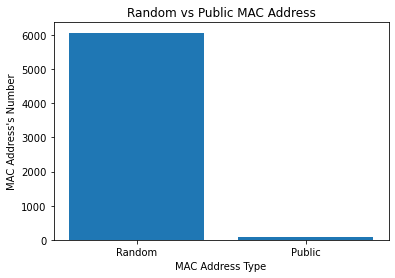

In [97]:
# plotRandomPublicMAC(data)
plotRandomPublicMAC(data_20220712)

Existe una clara victoria para las direcciones MAC aleatorias de todas las tramas recogidas por el ESP32.

Esto podría suponer un problema, aunque existen maneras para intentar minimizar todo lo posible el impacto de este efecto. Uno de ellos es el de seccionar en intervalos de tiempo cortos (en este caso de 5 minutos), de manera que aunque cambie de dirección dentro de ese intervalo, la variación en el total de dispositivos captados será mínimo y lo precisa posible.

## Evolución del número de dispositivos

Con la ayuda de un contador de personas instalado la puerta de la biblioteca, se ha realizado una medición de cuantas personas hay dentro. Podemos representar la evolución de este dato para comprobar si tiene una forma similar a la obtenida con los receptores BLE:

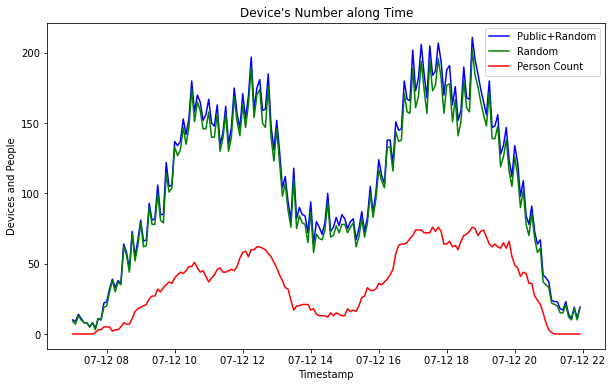

In [98]:
# plotTotalDevices(data, fullPersonCountInterval)
plotTotalDevices(data_20220712, fullPersonCountInterval_20220712)

Se puede apreciar claramente que las curvas poseen un parecido bastante interesante. La diferencia de amplitud entre el número de personas (rojo) y el número de dispositivos (azul y verde) se debe a que normalmente una persona cuenta con más de un dispositivo, por ejemplo, un móvil, portátil, auriculares, etc.

Además, podemos cargar los datos de distintos días para así poder comparar la evolución entre distintos días:

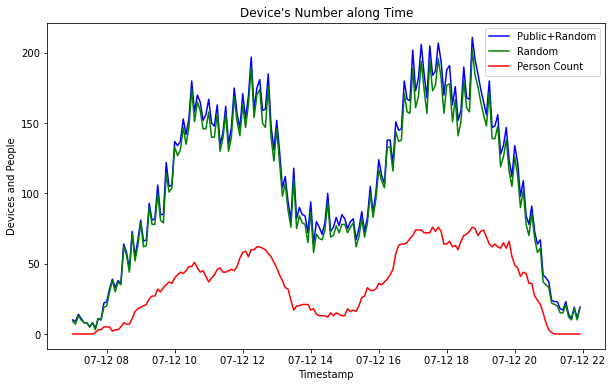

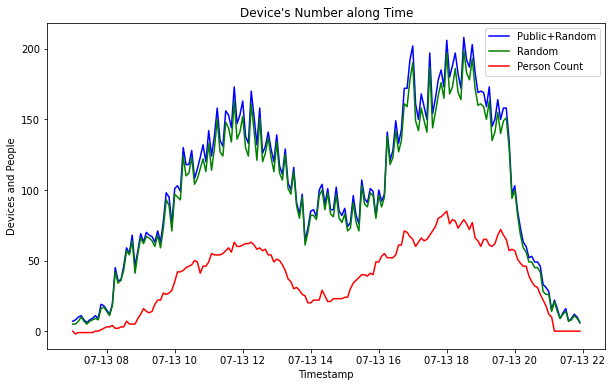

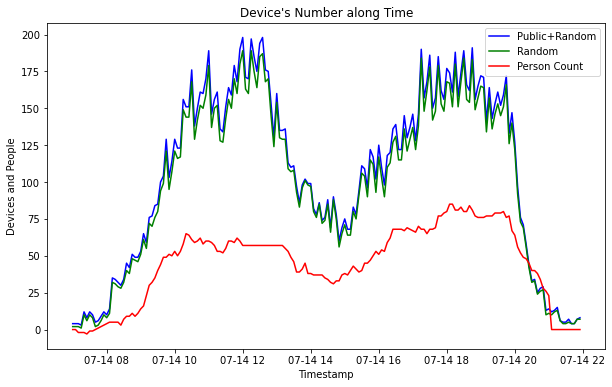

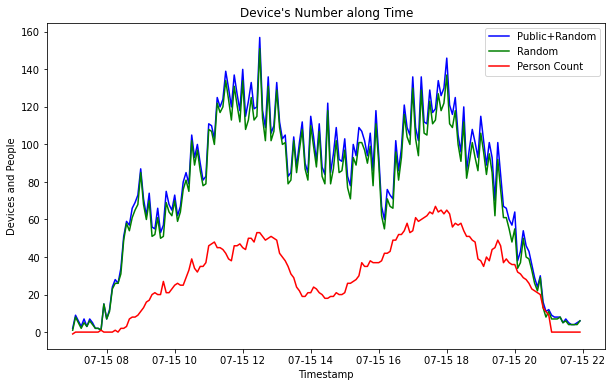

In [99]:
# plotTotalDevices(data, fullPersonCountInterval)
plotTotalDevices(data_20220712, fullPersonCountInterval_20220712)
plotTotalDevices(data_20220713, fullPersonCountInterval_20220713)
plotTotalDevices(data_20220714, fullPersonCountInterval_20220714)
plotTotalDevices(data_20220715, fullPersonCountInterval_20220715)

Como se puede ver, la forma de la gráfica no varía y lo único que varía es la amplitud.

Como medida adicional, podemos calcular el error que existe entre el número de dispositivos captados por los receptores y el número de personas que ha detectado el sensor instalado en la puerta, así podemos comparar rápidamente los resultados entre distintos días. Con esta función podemos elegir entre qué horas calcular el error y si usar todo el conjunto o solamente las direcciones privadas:

In [100]:
# error, quadraticError = errorCalc(data, fullPersonCountInterval, rand=True, startHour='8:00:00', finalHour='21:00:00')
error_20220712, quadraticError_20220712 = errorCalc(data_20220712, fullPersonCountInterval_20220712)
print('')
error_20220713, quadraticError_20220713 = errorCalc(data_20220713, fullPersonCountInterval_20220713)
print('')
error_20220714, quadraticError_20220714 = errorCalc(data_20220714, fullPersonCountInterval_20220714)
print('')
error_20220715, quadraticError_20220715 = errorCalc(data_20220715, fullPersonCountInterval_20220715)

El error medio del día es: -75.567
El error cuadrático medio del día es: 6432.471

El error medio del día es: -64.631
El error cuadrático medio del día es: 4860.669

El error medio del día es: -61.828
El error cuadrático medio del día es: 4844.083

El error medio del día es: -49.752
El error cuadrático medio del día es: 2972.732


Todas las funciones desarrolladas permiten elegir entre utilizar todo el conjunto de datos o únicamente las direcciones Random, para tener más flexibilidad a la hora de tratar los datos.

Para tener una visión más específica de dónde se concentran los dispositivos, vamos a aprovechar el hecho de tener repartidos los receptores en distintas localizaciones para visualizar la evolución de cada uno de los receptores:

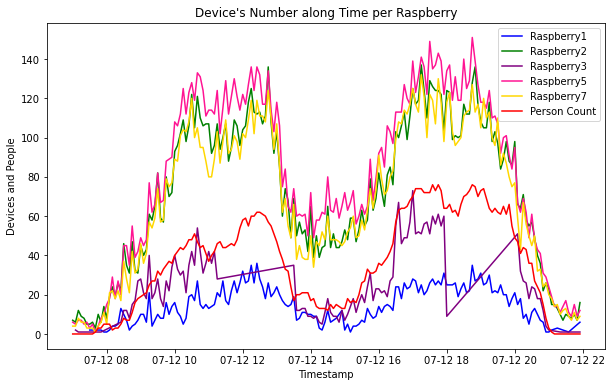

In [101]:
# plotTotalDevicesByRaspberry(data, fullPersonCountInterval, rand=True, initHour=None, endHour=None)
plotTotalDevicesByRaspberry(data_20220712, fullPersonCountInterval_20220712)

Observando el resultado obtenido, vemos que tiene sentido que tanto a tempranas como a altas horas del día (antes de las 08:00 cuando está cerrada y a partir de las 21:00 h cuando la biblioteca cierra) el número de dispositivos capturados decrezca.

Además, los datos tienen dos claros picos de actividad, situados entre las 10:00 h-13:00 h y 16:00 h-19:00 h. Vamos a hacer Zoom a una de las zonas mencionadas:

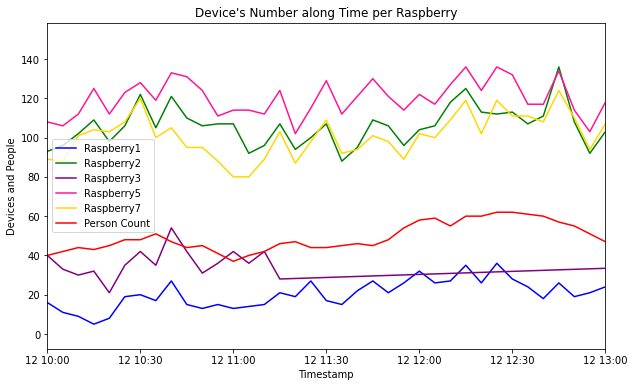

In [102]:
# plotTotalDevicesByRaspberry(data, fullPersonCountInterval, rand=True, initHour=None, endHour=None)
plotTotalDevicesByRaspberry(data_20220712, fullPersonCountInterval_20220712, initHour=10, endHour=13)

## Estudio de la potencia y número de mensajes

La potencia con la que se captan los mensajes también nos puede aportar mucha información, puede indicar que un dispositivo se está alejando o acercando a un receptor, o tal vez que se encuentra fuera del lugar de estudio.

Por ello también sería interesante visualizar tanto el número de paquetes recibidos por un dispositivo como la potencia con la que llegan, ya que si se encuentran pocos paquetes con poca potencia de un dispositivo, seguramente se traten de dispositivos externos o poco relevantes que se pueden eliminar para el cálculo, incorporarlos podría generar ruido en el procesado posterior.

Comenzaremos mostrando la evolución en el número de dispositivos contenidos en unos rangos de potencia variables con respecto a la mínima potencia captada:

1918
3878
3639
2839
1702
448


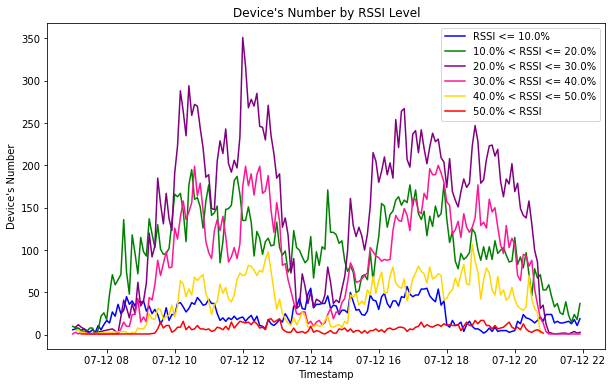

In [103]:
# plotTotalDevicesByRSSI(data, rand=True, initValue=10, endValue=50)
plotTotalDevicesByRSSI(data_20220712)

Lo más relevante de esta gráfica es que confirma que existen muy pocos dispositivos con alta potencia en recepción (rojo) y los dispositivos con muy poca potencia en recepción tampoco sno mucho mayores a los anteriores mencionados (azul). La mayoría de dispositivos se agrupa en unos niveles de señales medios.

Si nos centramos en el caso particular de cada receptor, podemos conseguir los siguientes resultados:

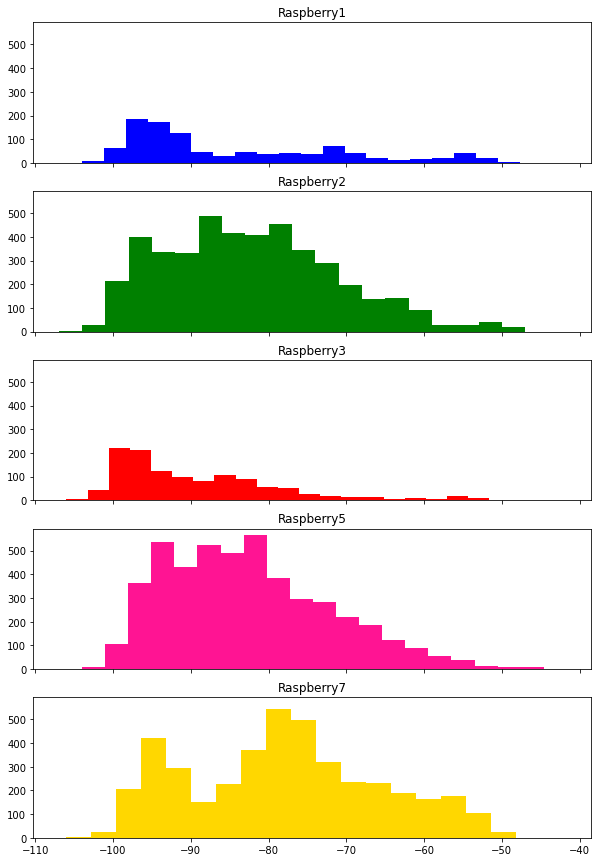

In [104]:
# histTotalDevicesByRSSIAndRaspberry(data, rand=True, bins=20)
histTotalDevicesByRSSIAndRaspberry(data_20220712)

Para continuar con lo anterior, necesitamos representar el número de mensajes recibidos por cada dispositivo. Sin embargo, esto puede ser costoso, ya que en cada conjunto de datos puede haber muchos dispositivos (miles) lo cual hace imposible su representación. Una posible solución es representar el número de dispositivos que han enviado un cierto número de mensajes, de manera similar al apartado anterior:

5592
2001
1147
851
712
1214


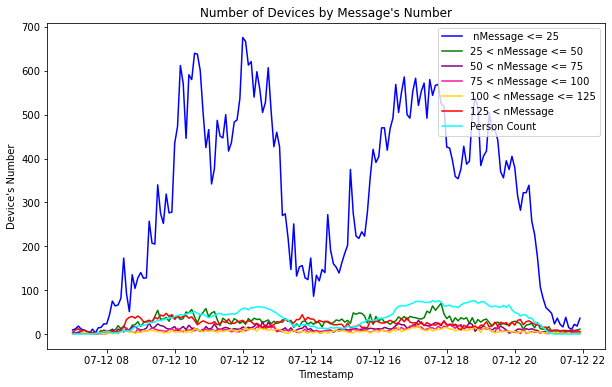

In [105]:
# plotTotalDevicesByMessage(data, fullPersonCountInterval, rand=True, initValue=25, endValue=125)
plotTotalDevicesByMessage(data_20220712, fullPersonCountInterval_20220712)

En principio, existen muchos dispositivos con muy pocos mensajes, lo que hace que el resto de curvas no se lean correctamente. Vamos a reducir la escala para poder apreciarlo mejor:

4793
3157
2329
1761
1252
2655


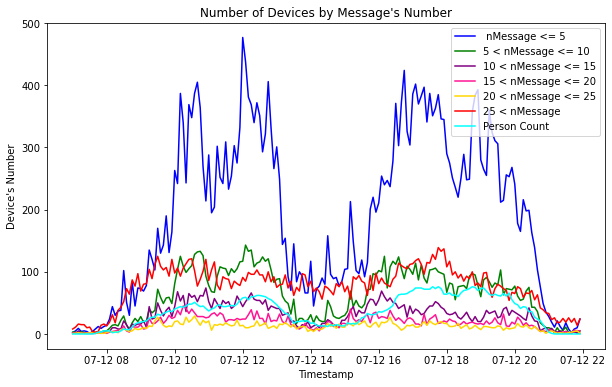

In [106]:
# plotTotalDevicesByMessage(data, fullPersonCountInterval, rand=True, initValue=25, endValue=125)
plotTotalDevicesByMessage(data_20220712, fullPersonCountInterval_20220712, initValue=5, endValue=25)

Con esta nueva vista, podemos asegurar que existen muchos dispositivos que envían muy pocos mensajes dentro del mismo intervalo de tiempo. Esto puede deberse a que sean dispositivos temporales, dispositivos externos a la biblioteca que están de paso o usuarios que se están moviendo dentro y no se quedan demasiado tiempo en un sitio fijo.

## Estudio de la sala Jose Villena

A partir de ahora, nos centraremos en los receptores desplegados en la principal sala de estudio, es decir, *Raspberry2*, *Raspberry5*, *Raspberry7*. Dado que comparten cobertura y sus evoluciones temporales son parecidas, podemos sacar algunas conclusiones a partir de los datos que nos aportan.

Por ejemplo, el número de direcciones MAC que encuentra cada receptor, que tanto por ciento de paquetes están por debajo de un umbral de potencia, saber si un dispositivo se ha registrado a la vez en más de un receptor o el tanto por ciento de dispositivos que ya estaban registrados durante el intervalo anterior.

In [107]:
# getMetricsRoom(data, rand=True, RSSIThreshold=-99)
getMetricsRoom(data_20220712)

Número dispositivos captados por la Raspberry2: 96
Número dispositivos captados por la Raspberry5: 99
Número dispositivos captados por la Raspberry7: 100

Número de mensajes captados por la Raspberry2: 442056
Número de mensajes captados por la Raspberry5: 636158
Número de mensajes captados por la Raspberry7: 424340

Tanto por ciento de mensajes por debajo de -99 dB en Raspberry2: 0.2414 %
Tanto por ciento de mensajes por debajo de -99 dB en Raspberry5: 0.0539 %
Tanto por ciento de mensajes por debajo de -99 dB en Raspberry7: 0.0504 %

Tanto por ciento de dispositivos con mensajes por debajo de -99 dB en Raspberry2: 1.42 %
Tanto por ciento de dispositivos con mensajes por debajo de -99 dB en Raspberry5: 0.6622 %
Tanto por ciento de dispositivos con mensajes por debajo de -99 dB en Raspberry7: 0.5082 %



Como se ha comentado anteriormente, un aspecto que nos puede dar confianza es que un mismo dispositivo sea detectado por más de un receptor en el mismo intervalo de tiempo, para ello recorreremos el datasheet dividido en intervalos de tiempo, comprobando por cuantos y cuáles receptores ha sido capturado ese mensaje.

Los receptores están distribuidos de tal manera que en la sala de estudio, dos de ellos están situados cerca de la pared (Raspberry2 y Raspberry7). Al otro lado de la pared hay un paseo por donde las personas pueden andar. Para intentar filtrar los dispositivos que se encuentran dentro de la biblioteca, podemos discriminarlos de tal manera que deban ser detectados por al menos dos receptores y que estos receptores no sean los que se encuentran instalados en la pared:

             Timestamp                MAC        Raspberry Total
0  2022-07-12 07:00:00  14:1b:f4:3c:f3:b5      Raspberry_5     1
1  2022-07-12 07:00:00  45:63:10:5b:19:8d      Raspberry_2     1
2  2022-07-12 07:00:00  66:68:ef:e1:40:19      Raspberry_2     1
3  2022-07-12 07:00:00  6b:47:3e:09:e4:ec  Raspberry_2_5_7     3
4  2022-07-12 07:00:00  6c:81:e5:45:1c:92  Raspberry_2_5_7     3
5  2022-07-12 07:00:00  7f:1c:1a:a0:6e:66      Raspberry_5     1
6  2022-07-12 07:00:00  c2:ce:06:f1:94:c4      Raspberry_2     1
7  2022-07-12 07:00:00  c6:d1:f4:e8:fa:1a  Raspberry_2_5_7     3
8  2022-07-12 07:00:00  e1:b1:0f:14:75:7d  Raspberry_2_5_7     3
9  2022-07-12 07:05:00  66:68:ef:e1:40:19      Raspberry_2     1

             Timestamp                MAC        Raspberry
0  2022-07-12 07:00:00  6b:47:3e:09:e4:ec  Raspberry_2_5_7
1  2022-07-12 07:00:00  6c:81:e5:45:1c:92  Raspberry_2_5_7
2  2022-07-12 07:00:00  c6:d1:f4:e8:fa:1a  Raspberry_2_5_7
3  2022-07-12 07:00:00  e1:b1:0f:14:75:7d  Raspb

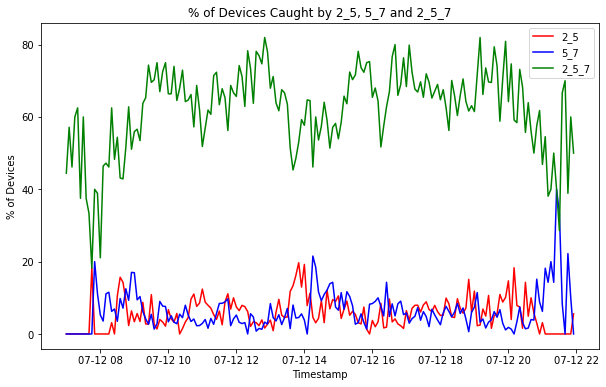

In [108]:
# devicesSummary, devicesOverlap, devicesOverlapRate = devicesOverlapRoom(data, time, rand=True)
devicesSummary_20220712, devicesOverlap_20220712, devicesOverlapRate_20220712 = devicesOverlapRoom(data_20220712, timeSeries_20220712)
# plotDevicesOverlapRoom(deviceOverlapRate)
plotDevicesOverlapRoom(devicesOverlapRate_20220712)

Al igual que es importante saber si un dispositivo se ha registrado en un mismo receptor en el mismo instante de tiempo, es interesante saber si ese dispositivo estaba previamente registrado, es decir, la continuidad del dispositivo en un receptor a lo largo de los instantes de tiempo, lo que indica que no se ha movido del lugar dándonos más confianza en el dato.

              Timestamp    Rate
0   2022-07-12 07:00:00       0
1   2022-07-12 07:05:00  71.429
2   2022-07-12 07:10:00  53.846
3   2022-07-12 07:15:00    60.0
4   2022-07-12 07:20:00    87.5
5   2022-07-12 07:25:00    87.5
6   2022-07-12 07:30:00    60.0
7   2022-07-12 07:35:00    50.0
8   2022-07-12 07:40:00   100.0
9   2022-07-12 07:45:00  27.273
10  2022-07-12 07:50:00    30.0
11  2022-07-12 07:55:00  44.444
12  2022-07-12 08:00:00  57.895
13  2022-07-12 08:05:00  32.143
14  2022-07-12 08:10:00  52.778
15  2022-07-12 08:15:00  34.615
16  2022-07-12 08:20:00  34.375
17  2022-07-12 08:25:00  65.517
18  2022-07-12 08:30:00  33.333
19  2022-07-12 08:35:00   50.98

              Timestamp                MAC isIn
0   2022-07-12 07:00:00  14:1b:f4:3c:f3:b5    N
1   2022-07-12 07:00:00  45:63:10:5b:19:8d    N
2   2022-07-12 07:00:00  66:68:ef:e1:40:19    N
3   2022-07-12 07:00:00  6b:47:3e:09:e4:ec    N
4   2022-07-12 07:00:00  6c:81:e5:45:1c:92    N
5   2022-07-12 07:00:00  7f:1c:1a:a0:6e

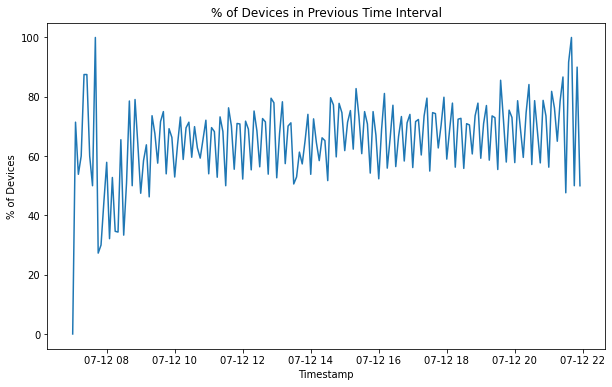

In [109]:
# devicesInPreviousInterval, devicesMACInPreviousInterval =  devicesOverlapRoomDetail(time, deviceSummary)
devicesInPreviousInterval_20220712, devicesMACInPreviousInterval_20220712 = devicesOverlapRoomDetail(timeSeries_20220712, devicesSummary_20220712)
# plotDevicesOverlapRoomDetail(devicesInPreviousInterval)
plotDevicesOverlapRoomDetail(devicesInPreviousInterval_20220712)

Los datos muestran que se detectan dispositivos en horas fuera del horario de apertura de la biblioteca, lo que podrían identificarse con personas que pasan por el exterior o dispositivos que ya existen dentro de la biblioteca, lo cuales podríamos eliminar del conjunto.

Este estudio se va a hacer entre las 07:00:00 de la mañana y las 07:30:00, además de entre las 21:30:00 y las 22:00:00.
Estas horas son modificables:

In [113]:
# devicesFirstHour, devicesSecondHour = devicesOffset(data, rand=True, firstValue='7:00:00', secondValue='21:30:00', interval=30)
devicesFirstHour_20220712, devicesSecondHour_20220712 = devicesOffset(data_20220712)

Número de dispositivos entre las 7:00:00 y las 07:30:00 : 8.571
Número de dispositivos entre las 21:30:00 y las 22:00:00 : 15.0


Los mapas de correlación son de mucha ayuda, ya que muestran cuan estrecha es la relación entre las columnas de datos. Podemos obtener fácilmente este mapa con lo siguiente:

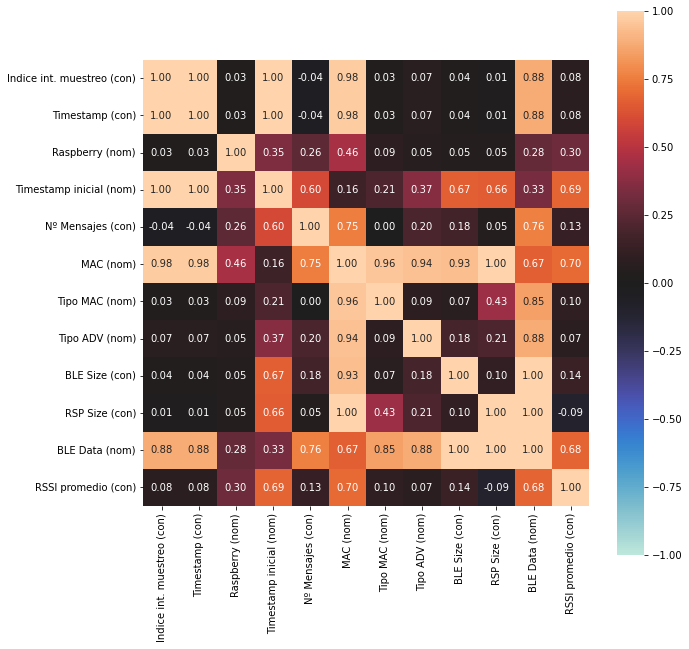

In [111]:
associations(data_20220712, figsize=(10, 10), mark_columns=True);